# Wannierisation (including SAWF)

This tutorial shows how to construct (Symmetry adapted) Wannier functions with WannierBerri, with magnetic symmetries. We will use the example of bcc Fe.

## 0. Compute QuantumEspresso files

in tthe tutorial repository only the input files for Quantum ESPRESSO are provided
to obtain the necessary files one needs to run
```
pw.x < Fe_pw_scf_in > Fe_pw_scf_out
pw.x < Fe_pw_nscf_in > Fe_pw_nscf_out
wannier90.x -pp Fe
pw2wannier90.x < Fe_pw2wan_in > Fe_pw2wan_out
```
 
## 1. Setup

First import modules and set up the parallel environment



In [13]:

import os

from matplotlib import pyplot as plt
import ray
import scipy
import wannierberri as wberri
import numpy as np
from termcolor import cprint

import warnings
import wannierberri as wb 
tested_version = '1.3.0'
if wb.__version__ != tested_version:
    warnings.warn(f'This tutorial was tested with version {tested_version} of wannierberri')

from wannierberri.parallel import Parallel

from pathlib import Path
path_data = Path("./pwscf/")  # adjust path if needed to point to the data in the tests fo wannier-berri repository

assert os.path.exists(path_data), f"Path {path_data} does not exist"

results_path = {}
results_grid = {}

# We do all calculations for three cases: 
#   1. With all magnetic symmetries (include_TR=True)
#   2. With only the spacegroup symmetries that preserve the magnetic order (include_TR=False)
#   3. Without any symmetries (include_TR=None)

include_TR_list = [True, False, None]  # None means no symmetry

try:
    ray.shutdown()
except:
    pass
parallel = Parallel(ray_init={"num_gpus": 0}) # use of gpus is not tested



/tmp/ipykernel_131134/74261731.py:14: UserWarning: This tutorial was tested with version 1.3.0 of wannierberri
  warnings.warn(f'This tutorial was tested with version {tested_version} of wannierberri')


initializing ray with  {'num_gpus': 0, 'num_cpus': None}


2025-05-14 16:31:15,157	INFO worker.py:1879 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


## 2. Read the bandstructure from Quantum ESPRESSO

we use the Bnadstructure object form irrep to read the bandstructure from Quantum ESPRESSO. It also can be used to read from VASP, ABINIT, etc. , see documentation of irrep for more details.



In [2]:

from irrep.bandstructure import BandStructure
assert os.path.exists(path_data), f"Path {path_data} does not exist"
  # adjust path if needed to point to the data in the tests fo wannier-berri repository
bandstructure = BandStructure(code='espresso',   # to work with VASP or abinit please refer to the documentation of irrep
                            prefix=str(path_data / "Fe"),
                            Ecut=100,
                            normalize=False,
                            magmom=[[0,0,1]],  # set the magnetic moments for a magnetic system (units do not matter)
                            include_TR=True)  # set include_TR=False if you do not want to include the symmetries involving time reversal
spacegroup = bandstructure.spacegroup
spacegroup.show()







 ---------- CRYSTAL STRUCTURE ---------- 


Cell vectors in angstroms:

      Vectors of DFT cell       |      Vectors of REF. cell      
a0 =  1.4350   1.4350   1.4350  |  a0 =  1.4350  -1.4350  -1.4350
a1 = -1.4350   1.4350   1.4350  |  a1 =  1.4350   1.4350  -1.4350
a2 = -1.4350  -1.4350   1.4350  |  a2 =  1.4350   1.4350   1.4350

Atomic positions in direct coordinates:

Atom type |   Position in DFT cell    |   Position in REF cell   
    1     |  0.0000   0.0000   0.0000 |  0.0000   0.0000   0.0000


 ---------- SPACE GROUP ----------- 


Space group: I4/mm'm' (# 139.537)
Number of unitary symmetries: 8 (mod. lattice translations)
Number of antiunitary symmetries: 8 (mod. lattice translations)

The transformation from the DFT cell to the reference cell of tables is given by: 
        |   1.0000  0.0000  0.0000 |
refUC = |   0.0000  1.0000  0.0000 |    shiftUC = [0. 0. 0.]
        |   0.0000  0.0000  1.0000 |


 ### 1 

rotation : |  1   0   0 |
           |  0   1   0 |
       

## 3 Choose projections

This is similar to wannier90. However, in this case the projections already include the symmetry information. 

In [3]:

from wannierberri.symmetry.projections import Projection, ProjectionsSet
# now set the transformations of WFs. Make sure, the projections are consistent with the amn file
proj_s = Projection(position_num = [[0,0,0]], orbital='s', spacegroup=spacegroup)
proj_p = Projection(position_num = [[0,0,0]], orbital='p', spacegroup=spacegroup)
proj_d = Projection(position_num = [[0,0,0]], orbital='d', spacegroup=spacegroup)
projections_set = ProjectionsSet(projections=[proj_s, proj_p, proj_d])


## 4 create the SymmetrizerSAWF object 


The `wannierberri.symemtry.sawf.SymmetrizerSAWF` class is used to store the information on how the dft bands, and the Wannier functions  transform under spac-group (ot magnetic group) symmetries. This information is used to construct the SAWF, to search for projections, and to symmetrize the system (using the System_R.symmetrize2 methos)

In spirit it is similar to the dmn file of Wannier90, but more developed and optimized.  Compared, to the wannier90.dmn file, the SytmmetrizerSAWF has the following advantages:

* The matrices D_wann and d_band are stored in block diagonal form, which saves memory and allows for faster calculations.
    - for d_band the blocks correspond to (almost) degenerate bands
    - for D_wann the blocks correspond to the same orbital at the same Wyckoff position
* The information on magnetic symmeties (which symmetry operation includes time reversal)
* The spacegroup is stored as an irrep.spacegroup.Spacegroup object, which allows for easy manipulation of the symmetry operations


In [4]:
symmetrizer = wberri.symmetry.sawf.SymmetrizerSAWF().from_irrep(bandstructure)
symmetrizer.set_D_wann_from_projections(projections_set)


# you can save it for later use
symmetrizer.to_npz("Fe_spd.sawf.npz")
# later can be read with
symmetrizer_read_npz = wberri.symmetry.sawf.SymmetrizerSAWF().from_npz("Fe_spd.sawf.npz")

mpgrid = [4 4 4], 64
orbitals = ['s']
orbitals = ['p']
orbitals = ['d']
calculating Wannier functions for s at [[0 0 0]]
calculating Wannier functions for p at [[0 0 0]]
calculating Wannier functions for d at [[0 0 0]]
D.shape [(13, 16, 2, 2), (13, 16, 6, 6), (13, 16, 10, 10)]
num_wann 18
D_wann_block_indices [[ 0  2]
 [ 2  8]
 [ 8 18]]
saving to Fe_spd.sawf.npz : 


## 5. Create the amn file

Note, that projections can be calculated directly form bandstructure object, and no need to evaluate them in the pw2wannier90 code. Still, one can use the amn file from pw2wannier90, but in this case one needs to be careful with the ordering of projections. Therefore, it is recommended to generate the amn file directly.


In [5]:
from wannierberri.w90files.amn import amn_from_bandstructure

amn = amn_from_bandstructure(bandstructure=bandstructure, projections=projections_set)

finding num points from 3 projections
Creating amn. Using projections_set 
ProjectionsSet with 9 Wannier functions and 0 free variables
Projection 0, 0, 0:['s'] with 1 Wannier functions on 1 points (1 per site)
Projection 0, 0, 0:['p'] with 3 Wannier functions on 1 points (3 per site)
Projection 0, 0, 0:['d'] with 5 Wannier functions on 1 points (5 per site)


/home/stepan/github/wannier-berri/wannierberri/symmetry/orbitals.py:256: RuntimeWarning: invalid value encountered in divide
  g_costheta = gk[:, 2] / gk_abs


## 6. Read and set w90 files

Read the files into w90data object, attach to it the created amn and symmetrizer objects. 

Then, one may check if the files eig and amn are consistent with the symmetrizer

In [6]:
w90data=wberri.w90files.Wannier90data(seedname=str(path_data/"Fe"), readfiles=["mmn","eig","win"])
# check the symmetries of the amn and eig files
w90data.set_symmetrizer(symmetrizer)
w90data.set_file("amn", amn)
print (f"eig is symmetric within the accuracy of : {symmetrizer.check_eig(w90data.eig)}")
print (f"amn is symmetric within the accuracy of : {symmetrizer.check_amn(w90data.amn, warning_precision=1e-4)}")   

print (f"eigenvalues at ik=0 : {w90data.eig.data[0]}")


kwargs for mmn are {'read_npz': True, 'write_npz': True}
calling w90 file with pwscf/Fe, mmn, tags=['data', 'neighbours', 'G'], read_npz=True, write_npz=True, kwargs={'npar': 32}
kwargs for eig are {'read_npz': True, 'write_npz': True}
calling w90 file with pwscf/Fe, eig, tags=['data'], read_npz=True, write_npz=True, kwargs={}
kwargs for win are {}
creating empty CheckPoint from Win file
kwargs for amn are {'read_npz': True, 'write_npz': True}
eig is symmetric within the accuracy of : 6.380193857771894e-10
ikirr=11, isym=1 : 0.00012789598633181155
ikirr=11, isym=2 : 0.00013646676080471002
ikirr=11, isym=5 : 0.00013284000713554629
ikirr=11, isym=6 : 0.00012401435135324474
ikirr=11, isym=8 : 0.0001236516753781976
ikirr=11, isym=11 : 0.00012886135751486978
ikirr=11, isym=12 : 0.00013679953944807817
ikirr=11, isym=15 : 0.00013189953253912415
ikirr=12, isym=2 : 0.00012643305087638707
ikirr=12, isym=3 : 0.00012643305087639981
ikirr=12, isym=4 : 0.0001788096787404169
ikirr=12, isym=5 : 0.0001

## 7. Wannierise

In [7]:


cprint (f"wannierising", "blue", attrs=["bold"])
#aidata.apply_outer_window(win_min=-8,win_max= 100 )
froz_max=25
w90data.wannierise( init = "amn",
                froz_min=4,
                froz_max=froz_max,
                print_progress_every=1,
                num_iter=31,
                conv_tol=1e-6,
                mix_ratio_z=1.0,
                localise=True,
                sitesym=True,
                )

wannierising
####################################################################################################
starting WFs
----------------------------------------------------------------------------------------------------
wannier centers and spreads
----------------------------------------------------------------------------------------------------
  0.000000000000    0.000000000000    0.000000000000   |     1.889432851205
  0.000000000000    0.000000000000    0.000000000000   |     1.850936215251
  0.000000000000    0.000000000000    0.000000000000   |     4.072628643562
  0.000000000000    0.000000000000    0.000000000000   |     3.541038965148
  0.000000000000    0.000000000000    0.000000000000   |     3.793181855849
  0.000000000000    0.000000000000    0.000000000000   |     3.529475313040
  0.000000000000    0.000000000000    0.000000000000   |     3.793181855849
  0.000000000000    0.000000000000    0.000000000000   |     3.529475313040
  0.000000000000    0.000000000000 

## 9. Create System_w90 object

In [8]:

system = wberri.system.System_w90(w90data= w90data, berry=True, transl_inv_JM=True,
                                  symmetrize=True)

setting Rvec
expjphase1 (18, 18, 12)
Real-space lattice:
 [[ 1.4349963  1.4349963  1.4349963]
 [-1.4349963  1.4349963  1.4349963]
 [-1.4349963 -1.4349963  1.4349963]]
Number of wannier functions: 18
Number of R points: 89
Recommended size of FFT grid [4 4 4]


## 8. Bands along path

### 8.1 calculate bands

In [9]:
# all kpoints given in reduced coordinates
path=wberri.Path(system,
                nodes=[
                    [0.0000, 0.0000, 0.0000 ],   #  G
                    [0.500 ,-0.5000, -0.5000],   #  H
                    [0.7500, 0.2500, -0.2500],   #  P
                    [0.5000, 0.0000, -0.5000],   #  N
                    [0.0000, 0.0000, 0.000  ]
                        ] , #  G
                labels=["G","H","P","N","G"],
                length=200 )   # length [ Ang] ~= 2*pi/dk

bands_path=wberri.evaluate_k_path(system,
                parallel=parallel,
                path=path,)



Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x72004412cbc0>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x72004413da30> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x72004412cbc0>
All calculators are compatible
Symmetrization switched off for Path
Grid is regular
The set of k points is a Path() with 215 points and labels {0: 'G', 70: 'H', 130: 'P', 165: 'N', 214: 'G'}
generating K_list
Done 
Done, sum of weights:215.0
processing 215 K poi

/home/stepan/github/wannier-berri/wannierberri/grid/path.py:163: UserWarning: symmetry is not used for a tabulation along path
  warnings.warn("symmetry is not used for a tabulation along path")


time for processing    215 K-points on  32 processes:     1.9697 ; per K-point          0.0092 ; proc-sec per K-point          0.2932
time1 =  0.0024595260620117188
Totally processed 215 K-points 
run() finished


### 8.2 plot bands

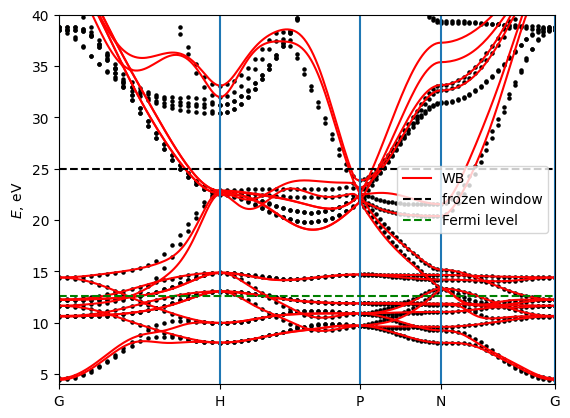

In [10]:

# plot the bands and compare with pw
# EF = 12

A = np.loadtxt("./pwscf/Fe_bands_pw.dat")
bohr_ang = scipy.constants.physical_constants['Bohr radius'][0] / 1e-10
alatt = 5.4235* bohr_ang
A[:,0]*= 2*np.pi/alatt
A[:,1] = A[:,1] 
plt.scatter(A[:,0], A[:,1], c="black", s=5)

    

bands_path.plot_path_fat(path,
                quantity=None,
                # save_file="Fe_bands.pdf",
                Eshift=0,
                Emin=-10, Emax=50,
                iband=None,
                mode="fatband",
                fatfactor=20,
                cut_k=False,
                linecolor="red",
                close_fig=False,
                show_fig=False,
                label=f"WB"
                )

plt.ylim(4, 40)
plt.hlines(froz_max, 0, A[-1,0], linestyles="dashed", label="frozen window", color="black")
plt.hlines(12.6, 0, A[-1,0], linestyles="dashed", label="Fermi level", color="green")
plt.legend()
plt.savefig("Fe_bands.pdf")


## 9. AHC and Ohmic conductivity

### 9.1 calculate 

In [11]:
results_grid = {}
efermi = np.linspace(12.4,12.8,1001)
param = dict(Efermi=efermi)
calculators_grid = {
     "CDOS": wberri.calculators.static.CumDOS(**param),
                "ohmic": wberri.calculators.static.Ohmic_FermiSea(**param),
                "ahc_internal": wberri.calculators.static.AHC(kwargs_formula={"external_terms":False}, **param),
            "ahc_external": wberri.calculators.static.AHC(kwargs_formula={"internal_terms":False}, **param ),	
}

grid =  wberri.Grid(system, NKFFT=6, NK=48)

result_grid = wberri.run(system, grid, calculators_grid, 
                                        fout_name="Fe_grid",
                                        adpt_num_iter=0,
                                        symmetrize=False,  # we do not symmetrize here so that we can chaeck how symmetric are the WFs
                                        use_irred_kpt=False,
                                        print_progress_step=1,
                                        parallel=parallel,
                                        print_Kpoints=False,
                                        )




# plot the bands to compare with pw





Starting run()
Using the follwing calculators : 
############################################################

 'CDOS'  :  <wannierberri.calculators.static.CumDOS object at 0x71fff043ac30>  : Cumulative density of states
 'ohmic'  :  <wannierberri.calculators.static.Ohmic_FermiSea object at 0x720044770920>  : Ohmic conductivity (:math:`S/m`)

        | With Fermi sea integral. Eq(31) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`__
        | Output: :math:`\sigma_{\alpha\beta} = e^2/\hbar \tau \int [dk] \partial_\beta v_\alpha f`for \tau=1fs| Instruction: :math:`j_\alpha = \sigma_{\alpha\beta} E_\beta`
 'ahc_internal'  :  <wannierberri.calculators.static.AHC object at 0x71fff02f07d0>  : Anomalous Hall conductivity (:math:`s^3 \cdot A^2 / (kg \cdot m^3) = S/m`)

        | With Fermi sea integral Eq(11) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`__
        | Output: :math:`O = -e^2/\hbar \int [dk] \Omega f`
        | Instruction: :math:`j_\alpha = \sigma_

### 5.2 Plot 

/tmp/ipykernel_131134/545839208.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


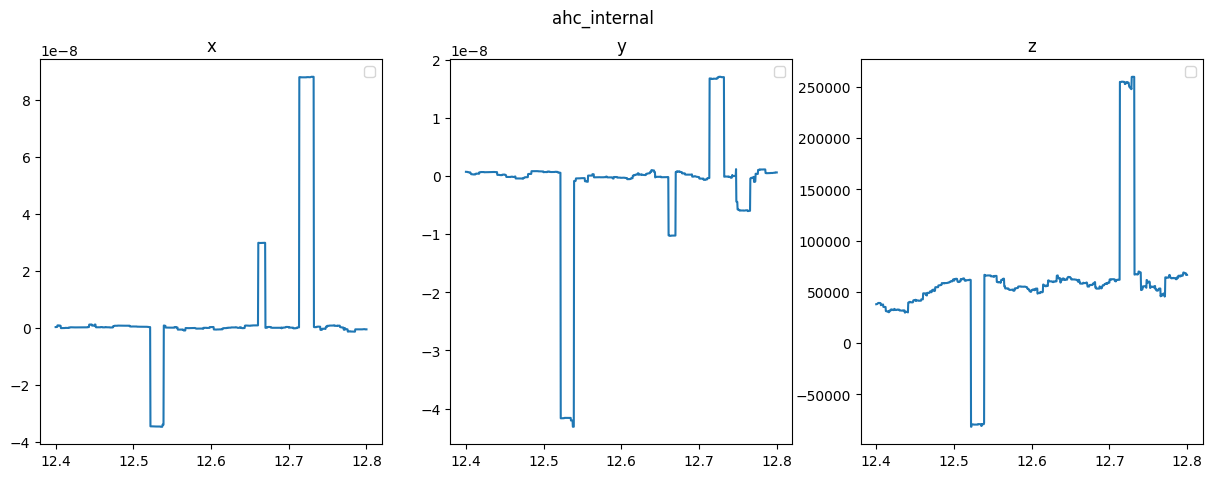

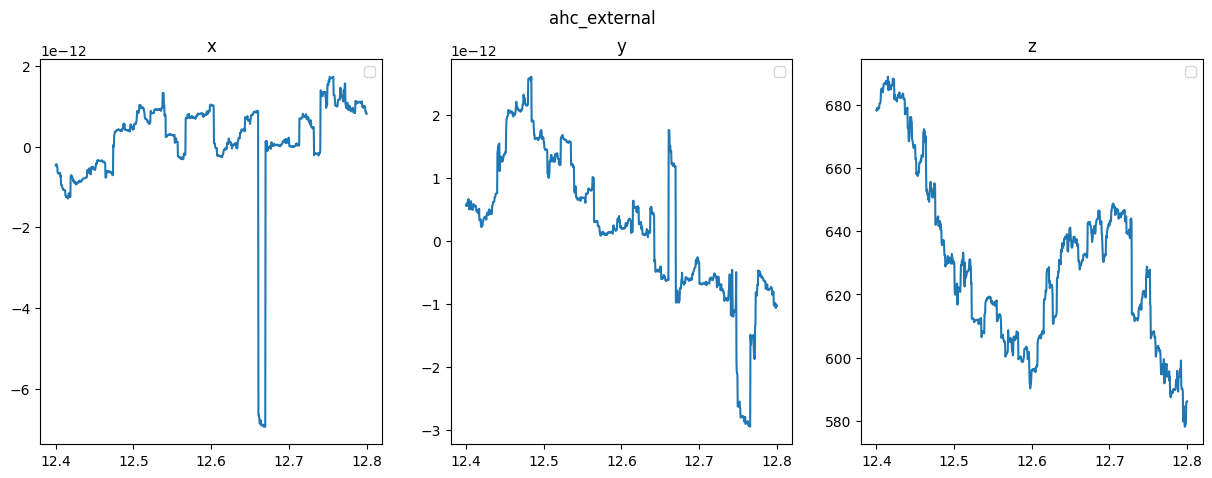

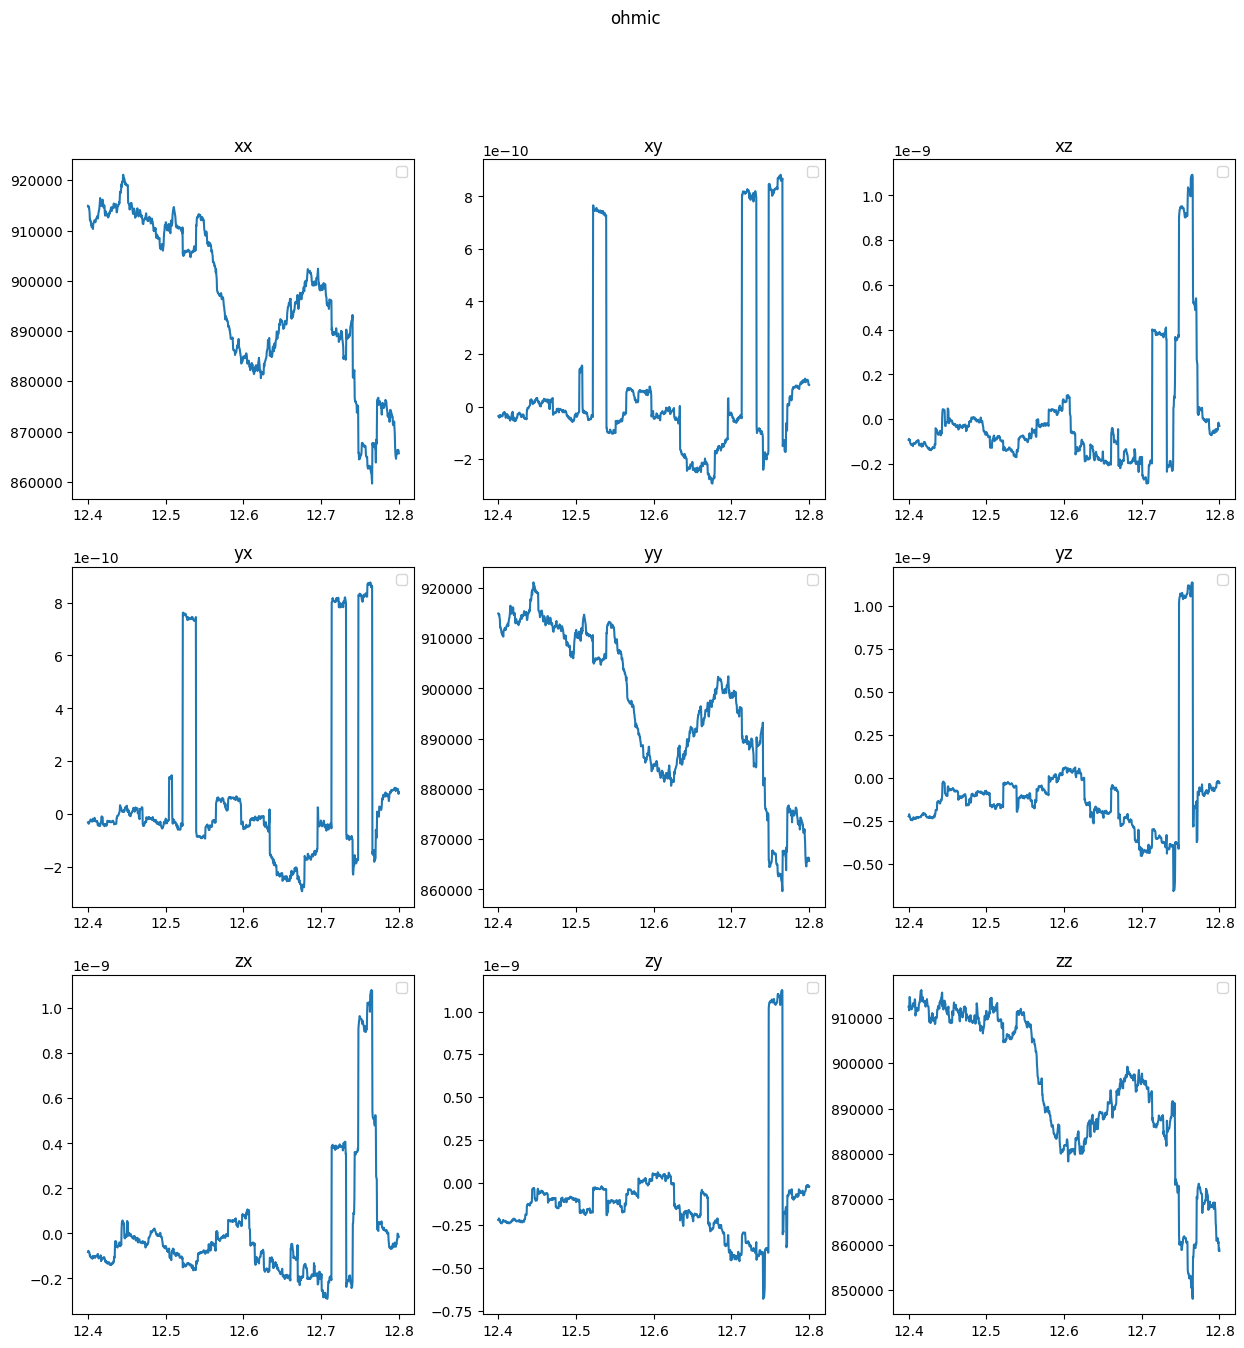

In [12]:
def plotxyz(axes, x, data, pre = "", label="",ls="-"):
    for i in range(3):
        ax =axes[i]
        ax.plot(x, data[:,i], ls, label=label)
        ax.set_title(f"{pre}{'xyz'[i]}")



quantities =  ["ahc_internal", "ahc_external","ohmic"]
linestyles = {k:v for k,v in zip( include_TR_list, ["-", "--", "-."])}
    
nfig = len(quantities)
for quantity in quantities:
    fig = None
    res = result_grid.results[quantity]
    data = res.data
    E = res.Energies[0]
    if fig is None:
        if data.ndim == 2:
            nfigx = 1
            nfigy = data.shape[1]
        elif data.ndim == 3:
            nfigx = data.shape[1]
            nfigy = data.shape[2]
        fig, axes = plt.subplots(nfigx, nfigy, figsize=(5*nfigy,5*nfigx))
    if nfigx ==1:
        plotxyz(axes, E, data)
    else:
        for i in range(nfigx):
            plotxyz(axes[i], E, data[:,i], pre="xyz"[i], )
    for ax in axes.flat:
        ax.legend()
    fig.suptitle(quantity)
    plt.show()
    plt.close()
    
        
